In [1]:
# Import standard libraries
import os
import random
import math
import numpy as np
import pandas as pd
import PIL
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
from tqdm import tqdm
import copy

# Import PyTorch and TorchVision libraries
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader, Dataset, RandomSampler
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
import torchvision.transforms.functional as tF
from skimage import io, transform
print('Pillow version:', PIL.__version__)

Pillow version: 6.1.0


In [2]:
%matplotlib inline
USE_GPU = True
CUDA_LAUNCH_BLOCKING = 1
print(torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

True


For the purpose of this project, the original Galaxy Zoo Kaggle competition objective is modified. Since the various classes provided (37), are not exclusive (except for class 1), but result from a crowdsourcing survey based on a decision tree, only the first few levels of the tree will be used in this exploration of VAEs. With the first few, it is possible to classify the galaxies as round (0), oval(1), cigar shaped (2), disk shaped (3), spiral (4) or other(5) (e.g. star/artifact, ...).

**NOTE**: we decided to classify the star or artifact class from the original competition as "other" in this study due to only having 59 of such samples in a population of  61578 galaxies. Even with a subset of 8000 training samples, 59 samples (at best) do not provide adequate class representation.

To find the labels corresponding to each class, we unwrap the first layers of the tree by first considering if the galaxy is smooth or if it has features. If it is smooth, we divide the smooth categorization values (Class 7 originally) by the probability found at the first level and take the highest resulting number as a class indicator. The same process is applied recursively to determine the remaining galaxy classes. 

These classes will later be used to guide the reconstruction of the original image. They also allow for a characterization of the latent space by feeding them to t-SNE along with sample latent vectors (means).

**NOTE**: while this unwrapping process could be applied from root to leaf to extract all possible classes of galaxies, the fact that only 8000 (training) samples are being used increases the risk of having poor class representation during training which can negatively affect the overall quality of the classification. By limiting the classification task to the 6 listed categories, 8000 samples allow for satisfactory feature classification.

In [3]:
# Galaxy classification
# NOTE: stars or artifact are lumped into other due to having too few samples (59) of this class
categories = {
    0: 'ROUND',    # smooth galaxy, overall round
    1: 'OVAL',     # smooth galaxy, overall oval
    2: 'CIGAR',    # smooth galaxy, cigar shape
    3: 'DISK',     # galaxy with features, disk viewed edge on
    4: 'SPIRAL',   # galaxy with features, spirals
    5: 'OTHER'     # galaxy with features, other
}

In [4]:
# DATALOADING
class GalaxyDataset(Dataset):
    """Galaxy Zoo dataset"""
    
    def __init__(self, dataset, root_dir, norm, size=7000, sanity_check=None, transform=None):
        # Read and shuffle Galaxy dataframe before taking subset
        self.galaxies = pd.read_csv(dataset)
        self.galaxies = self.galaxies.reindex(np.random.permutation(self.galaxies.index))
        self.galaxies = self.galaxies[:size]

        self.root_dir = root_dir
        self.norm = norm
        self.transform = transform
        
        # Load targets and data
        self.first_layer = self.galaxies.iloc[:, 1:4].to_numpy()
        self.targets = np.argmax(self.galaxies.iloc[:, 1:4].to_numpy(), axis=1)
        self.data = [os.path.join(root_dir, str(galaxy) + ".jpg") for galaxy in self.galaxies['GalaxyID']]
        
        
        if sanity_check is not None:
            self.data = [self.data[sanity_check]]
            self.targets = [self.targets[sanity_check]]

        assert (len(self.data) == len(self.targets))
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        """Images are read as required"""
        
        image = Image.open(self.data[idx])
        label = self.get_label(idx)

        if self.transform:
            tens = self.transform(image)
            max_val = tens.max()

        return tens/max_val, transforms.ToTensor()(image), label
    
    def get_label(self, index):
        clas = np.argmax(self.first_layer[index])
        first_prob = np.max(self.first_layer[index])
        if clas == 0:
            second_layer = np.argmax(self.galaxies.iloc[index, 16:19].to_numpy() / first_prob)
            label = second_layer # 0, 1 or 2
        elif clas == 1:
            # 2. Is it edge-on?
            second_clas = np.argmax(self.galaxies.iloc[index, 4:6].to_numpy() / first_prob)
            second_prob = np.max(self.galaxies.iloc[index, 4:6].to_numpy() / first_prob)
            if second_clas == 0:
                label = 3 # disk
            else:
                # 3. Is there a bar?
                third_prob = np.max(self.galaxies.iloc[index, 6:8].to_numpy() / second_prob)
                # 4. Is there a spiral pattern?
                fourth_clas = np.argmax(self.galaxies.iloc[index, 8:10].to_numpy() / third_prob)
                if fourth_clas == 0:
                    label = 4 # spiral
                else:
                    label = 5 # other
        else:
            label = 4
        return label
    
    def get_image(self, idx):
        """Get original PIL image"""
        return Image.open(self.data[idx])

In [5]:
# PREPROCESSING
class Invert(object):
    """Inverts the color channels of an PIL Image
    while leaving intact the alpha channel.
    """
    
    def invert(self, img):
        r"""Invert the input PIL Image.
        Args:
            img (PIL Image): Image to be inverted.
        Returns:
            PIL Image: Inverted image.
        """
        if not tF._is_pil_image(img):
            raise TypeError('img should be PIL Image. Got {}'.format(type(img)))

        if img.mode == 'RGBA':
            r, g, b, a = img.split()
            rgb = Image.merge('RGB', (r, g, b))
            inv = ImageOps.invert(rgb)
            r, g, b = inv.split()
            inv = Image.merge('RGBA', (r, g, b, a))
        elif img.mode == 'LA':
            l, a = img.split()
            l = ImageOps.invert(l)
            inv = Image.merge('LA', (l, a))
        else:
            inv = ImageOps.invert(img)
        return inv

    def __call__(self, img):
        """
        Args:
            img (PIL Image): Image to be inverted.
        Returns:
            PIL Image: Inverted image.
        """
        return self.invert(img)

    def __repr__(self):
        return self.__class__.__name__ + '()' 

### 5.0 Preprocessing

Applying generative models to images of galaxy is challenging in its own right due to a very large feature space and high dynamic intensity ranges. While large feature spaces are not uncommon in applied machine learning and computer vision, high dynamic range (HDR) is pushed to the extremem when it comes to space imagery. The mostly dark/black background of outer space is in high contrast with the center of the galaxy in most images; however, many galaxy features can be found following a circular (sometime spiralling) pattern away from its center, but these often go unnoticed due to the uniform blackness of the surroundings. For this reason, image normalization and HDR tone mapping tools (e.g. Reinhardt, Drago) are seen as valuable preprocessing steps. While only the former was experimented with in this project, the latter represents an interesting research avenue for future work in this area. Domain knowledge would also be useful to target preprocessing steps to known distinctive features.

Inspired by results from Ravanbakhsh et al. ([source 4](https://arxiv.org/pdf/1609.05796.pdf)), we tried to invert the color channels of the Galaxy-Zoo images, in the hope of extracting more well-defined features than is currently possible with their black-background counterparts. Some sample reconstructions are shown below.

![invert_example1](./invert/sample0.png) ![invert_example2](./invert/sample1.png)

While these reconstructions successfully removed some of the background noise, the lack of dynamic range in the intensities made the quality of the results harder to interpret. For this reason, it was decided to simply normalize the original cropped images to [0, 1].

In [6]:
DATAPATH = "./galaxy-zoo-the-galaxy-challenge/images_training_rev1/"
DATASET = "./galaxy-zoo-the-galaxy-challenge/training_solutions_rev1.csv"

# Normalized mean and variance over entire training set
norm = ([0.04573854, 0.04023606, 0.03000044],
        [0.08401006, 0.07076452, 0.06076583])

norm2 = ([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])



# Data loading
train_transform = transforms.Compose([ # NOTE: by default, conv layers pad with zeros --> black
#     Invert(), # invert colour channels to have galaxies stand out more easily on white background
    transforms.CenterCrop(300), # 50% center crop to get most features
    transforms.Resize(128), # resize for computational feasibility
    transforms.ToTensor(), 
#     transforms.Normalize(*norm) # normalization due to high dynamic range of features
])

# 8000 training samples(80%) + 2000 testing samples (20%) = 10000 random samples
dataset = GalaxyDataset(DATASET, DATAPATH, norm, transform=train_transform, size=10000)
sanity_dataset = GalaxyDataset(DATASET, DATAPATH, norm, sanity_check=1)

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [8000, 2000])

print(len(train_dataset))
print(len(test_dataset))
print(len(sanity_dataset))

8000
2000
1


In [7]:
WORKERS = 6
train_loader = DataLoader(train_dataset, batch_size=32, num_workers=WORKERS, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=4, num_workers=WORKERS, shuffle=False, drop_last=True)
sanity_loader = DataLoader(sanity_dataset, batch_size=1, num_workers=WORKERS, shuffle=False)

### 5.1 Minimizing reconstruction error

In this section, we evaluate different reconstruction metrics for a (variational) autoencoder. The KL divergence loss was ignored due to it vanishing early with the current implementation (the reason and mitigation measures will be discussed in the following section, where both reconstruction and KL divergence losses are combined).

Specifically, binary cross entropy (BCE) and mean squared error (MSE) are evaluated as galaxy reconstruction metrics on a (V)AE model trained for 200 epochs. Sample reconstructions based on each metric are compared below

A brief survey of the existing literature suggested that a latent dimension of 128 worked well with RGB images of size 128x128, which represents a compression of 384 ($3\times128\times128/128 = 384$). This parameter can always be increased if the training isn't optimal. Some tests were performed with $z_{dim}=512$, but the results from the smaller latent space were deemed sufficient, which also meant that the training process would be significantly faster. Keeping a conv-convTranspose VAE architecture, the larger model had 88 million trainable parameters, against 5.5 million for the smaller model.

The main difference between BCE and MSE is that BCE is an asymmetric loss function, whereas MSE is symmetric. This means that MSE penalizes predictions that are off from the ground truth equally; whether the prediction is higher or lower than the truth does not matter. On the other hand, BCE will penalize an overshoot more than an undershoot if the true intensity is high, and vice versa for a low true intensity. This can cause excessive blurriness in a reconstruction which is undesired. However, when appropriately tuned, both losses produce acceptable results, therefore testing is encouraged to determine which metric best suits the application.

#### BCE

![bce_training](./goal1/bce_training.png)

The AE was trained for 200 epochs, where the losses in a given batch are averaged at each iteration (instead of summing the losses). Training is slow but the loss continued to decrease over the 200 epochs. The results could therefore easily be improved by training the network for additional epochs. The following examples show the medium quality of the reconstructions, which suffer from blurriness, which is common in (V)AEs.

![example1](./goal1/bce_example3.png)

This example, while blurry, shows how the defect in the original image is filled in by the decoder. This is a nice feature that "comes for free" with (V)AE which can improve the robustness of the reconstruction when subject to corrupted or missing information.

![example2](./goal1/bce_example4.png)

In this example, we start to see lower level features being captured by (V)AE, as the spiral galaxy becomes noticeable. These features will be useful for the classification of the various galaxies in the following sections; these features will only become more apparent as the training proceeds further.

#### MSE
![mse_training](./goal1/mse_training.png)

The AE was trained for 200 epochs, where the losses in a given batch are averaged at each iteration (instead of summing the losses). In the following examples, we see similar reconstruction quality, with the first one showcasing the generative ability of the network to overcome missing information.

![example3](./goal1/mse_example3.png)

![example4](./goal1/mse_example4.png)

In general, qualitatively evaluating the quality of a reconstruction compared to the original is not sufficient as both BCE and MSE do not account for the galaxy features. In the following steps, we will constrain the network to approximate the desired latent prior ($p(z)$) by imposing that the Kullback-Leibler divergence between the probabilistic encoder $q(z|x)$ and $p(z)$ be minimized, alongside the reconstruction loss. The KL loss will act as a regularizer on the latent space, but training on the total loss can become tricky as each component needs to be appropriately balanced.

### 5.2 Generative model

The first model (architecture 0) is a basic convolutional VAE network used to produce the reconstructions above (without KL loss). A Pytorch [example](https://github.com/pytorch/examples/blob/master/vae/main.py) and two existing implementations were consulted to come up with this first model ([source 1](https://github.com/L1aoXingyu/pytorch-beginner/blob/master/08-AutoEncoder/conv_autoencoder.py), [source 2](https://github.com/bhpfelix/Variational-Autoencoder-PyTorch/blob/master/src/vanila_vae.py)).

In [8]:
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torch.autograd import Variable
from torchvision.utils import save_image
from torchvision import datasets, transforms
from torchvision.utils import save_image
from sklearn.manifold import TSNE

In [9]:
# General convolutional VAE (architecture 0)
class VAE(nn.Module):
    def __init__(self, input_channels=3, zdim=128, image_size=28):
        super(VAE, self).__init__()
        self.z_dim = zdim
        self.img_size = image_size
        # encoder part
        self.encoder_conv1 = nn.Conv2d(input_channels, zdim//16, 3, stride=2, padding=1)
        self.encoder_bn1 = nn.BatchNorm2d(zdim//16)
        self.encoder_conv2 = nn.Conv2d(zdim//16, zdim//8, 3, stride=2, padding=1)
        self.encoder_bn2 = nn.BatchNorm2d(zdim//8)
        self.encoder_conv3 = nn.Conv2d(zdim//8, zdim//4, 3, stride=2, padding=1)
        self.encoder_bn3 = nn.BatchNorm2d(zdim//4)
        
        # bottleneck
        self.fc1 = nn.Linear(2048, 512)
        self.fc21 = nn.Linear(512, zdim)
        self.fc22 = nn.Linear(512, zdim)
        self.fc3 = nn.Linear(zdim, 512)
        self.fc4 = nn.Linear(512, 2048)
                    
        # decoder part
        self.decoder_conv1 = nn.ConvTranspose2d(2048, zdim//4, kernel_size=7, stride=2)
        self.decoder_bn1 = nn.BatchNorm2d(zdim//4)
        self.decoder_conv2 = nn.ConvTranspose2d(zdim//4, zdim//8, kernel_size=3, stride=2, padding=1)
        self.decoder_bn2 = nn.BatchNorm2d(zdim//8)
        self.decoder_conv3 = nn.ConvTranspose2d(zdim//8, zdim//16, kernel_size=3, stride=2, padding=1)
        self.decoder_bn3 = nn.BatchNorm2d(zdim//16)
        self.decoder_conv4 = nn.ConvTranspose2d(zdim//16, input_channels, kernel_size=3, stride=2, padding=1)
        self.sig = nn.Sigmoid()
        
        self.initialize_weights()
#         nn.init.constant_(self.fc22.weight, 0.00)
        

    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
#                 nn.init.xavier_normal_(m.weight)#, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

        
    def encode(self, x):
        x1 = F.leaky_relu(self.encoder_conv1(x), negative_slope=0.2)
        x2 = F.leaky_relu(self.encoder_conv2(x1), negative_slope=0.2)
        x3 = F.leaky_relu(self.encoder_conv3(x2), negative_slope=0.2)
        x3 = F.max_pool2d(x3, 2)
        h1 = self.fc1(x3.view(-1, 2048))
        return self.fc21(h1), self.fc22(h1)

        
    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        h4 = self.fc4(h3)
        z1 = F.relu(self.decoder_conv1(h4.view(-1, 2048, 1, 1)))
        z2 = F.relu(self.decoder_conv2(z1))
        z3 = F.relu(self.decoder_conv3(z2))
        z4 = self.sig(F.interpolate(self.decoder_conv4(z3), 128, mode='bilinear', align_corners=True))
        return z4
        
    def reparameterize(self, mu, log_var):
        # we sample eps = N(0, 1) instead of Q(z|x)
        # z = z_means + exp(0.5 * z_log_var) * eps
        eps = torch.randn_like(mu)
        eps = eps.cuda()
        return mu + torch.exp(0.5 * log_var)*eps
    
    def get_latent_var(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return z
        
    def forward(self, x):
        mu, logvar = self.encode(x)
#         print("mu, logvar: {}, {}".format(mu, logvar))
        z = self.reparameterize(mu, logvar)
#         print("z: {}".format(z))
        return self.decode(z), mu, logvar


### 5.2.1 VAE Architecture 1: feed-forward NN

Taking a step back in terms of model complexity, architecture 1 consists in a simple feedforward neural network with 1 hidden layer containing 512 units; the latent space was also made to be of size 512. What the model gains in simplicity, it loses in feature capture, in the absence of convultional operation (see reconstructions below).

**Number of parameters**: 75547648

In [10]:
# Deep feed-forward neural network (w/ 512 unites) (architecture 1)
class FcVAE(nn.Module):
    def __init__(self, input_channels=3, image_size=128, hdim=512):
        super(FcVAE, self).__init__()
        
        # bottleneck
        self.fc11 = nn.Linear(input_channels*image_size*image_size, hdim)
        self.fc12 = nn.Linear(input_channels*image_size*image_size, hdim)
        self.fc2 = nn.Linear(hdim, input_channels*image_size*image_size)
#         self.init_weights()

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            # NOTE: import to init logvar dense layer to zero to prevent NaNs
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

        
    def encode(self, x):
        return self.fc11(x), self.fc12(x)

    
    def decode(self, z):
        return torch.sigmoid(self.fc2(z))
 

    def reparameterize(self, mu, log_var):
        # we sample eps = N(0, 1) instead of Q(z|x)
        # z = z_means + exp(0.5 * z_log_var) * eps
        eps = torch.randn_like(mu)
        eps = eps.cuda()
        return mu + torch.exp(0.5 * log_var)*eps
        
    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, x.shape[1]*x.shape[2]*x.shape[3]))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

Despite having the simplest architecture, the results obtained after training the feedforward architecture for 51 epochs were of high quality, perhaps owing to the fact that the fully-connected model had 2.3x and 3.25x times the number of trainable parameters when compared to the ConvNet and ResNet architectures respectively. The total loss (averaged over all batches at each epoch) may appear to be a little rocky, but the general trend can be seen to be decreasing overall.

![fc_training](./fc/training.png)


The blurriness typically associated with VAE reconstructions is not as noticeable and the reconstructed galaxies even appear more vibrant than the originals in certain cases (see below). It is important to note that the poor resolution of certain images can also be attributed in part to the cropping and resizing of the training images. Noise which can be seen in the background of certain original images (and which can sometimes be mistaken for relevant features in a convolutional architecture) is absent from these results. Samples of each classes are shown below to illustrate some of the strengths and weaknesses of the model.

![fc_sample0](./fc/sample0.png)
![fc_sample1](./fc/sample1.png)
![fc_sample2](./fc/sample2.png)
![fc_sample3](./fc/sample3.png)
![fc_sample4](./fc/sample4.png)
![fc_sample5](./fc/sample5.png)
![fc_tnse](./fc/tsne_last.png)
The labels in the above plot correspond to the reconstruction labels in the images above.

Overall, the reconstructions have less known and a better distribution of colours to represent the high dynamic range of the original image. Faint features such as the spirals in class 4 are still captured in the reconstruction.

The latent space representation of each class can be seen in the tsne plot after 50 epochs. While clusters have began to form (especially for disk type galaxies in lime green), they are not as well-defined as one would expect with a simpler dataset such as MNIST. Improving training might help with clustering, but it appears some of the classes are simply to similar to one another to have a clear distinction in latent space. For instance, latent representations of round and oval galaxies have quite a bit of overlap (in blue). We do see an overall distinction between the blue cluster and the orange one, showing the correct separation of spiral-shaped galaxies from circular-shaped ones.

Also, it appears there are too few cigar shaped galaxies to obtain a clear distinction, although we do see the emergence of localized clusters (in cyan). Finally, we would expect the "other" class to be uniformly distributed over the latent space, as the way this project was setup did not allow for better classification of these galaxy types. In future iterations, the latent space visualization could only gain from better categorization of class 6 (i.e. other), as well as having more samples to train on.

These results were deemed sufficient for this project as the end latent space representation showed clear improvement over earlier ones, as demonstrated by the following progression (NOTE: original size images can be found in the submission folder)

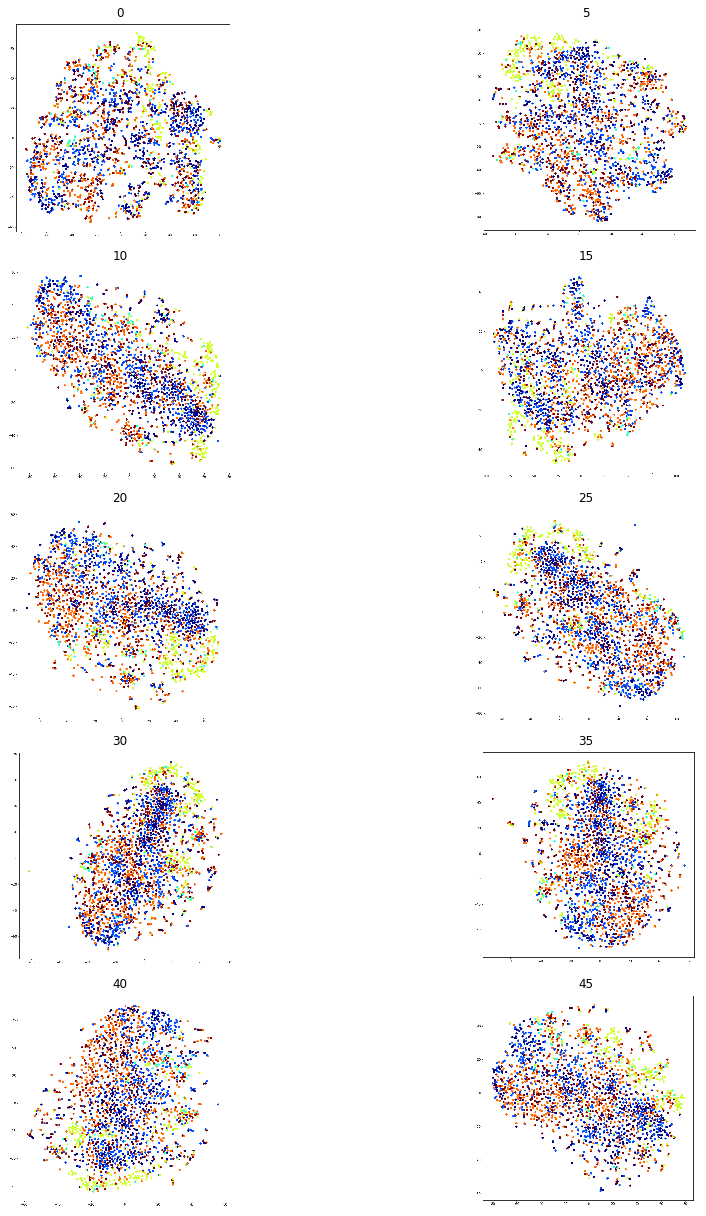

In [11]:
fig = plt.figure(figsize=(17, 17))
ax = [plt.subplot(5,2,i+1) for i in range(10)]
filenames = ["./fc/tsne000.png", "./fc/tsne005.png", "./fc/tsne010.png", "./fc/tsne015.png", "./fc/tsne020.png",
            "./fc/tsne025.png", "./fc/tsne030.png", "./fc/tsne035.png", "./fc/tsne040.png", "./fc/tsne045.png"]
for i, a in enumerate(ax):
    img = plt.imread(filenames[i])
    a.imshow(img)
    a.set_title(str(5*i))
    a.axis('off')

plt.subplots_adjust(wspace=0.00001, hspace=0.0001)
plt.tight_layout()

#### Testing saved FC model

In [12]:
# Loading the model for inference
fc_model = FcVAE(input_channels=3, image_size=128, hdim=512)
fc_model.load_state_dict(torch.load("./fc/fcnet_ep050.path"))
fc_model = fc_model.cuda()
fc_model.eval()

FcVAE(
  (fc11): Linear(in_features=49152, out_features=512, bias=True)
  (fc12): Linear(in_features=49152, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=49152, bias=True)
)

Text(0.5, 1.0, 'Reconstructed 4')

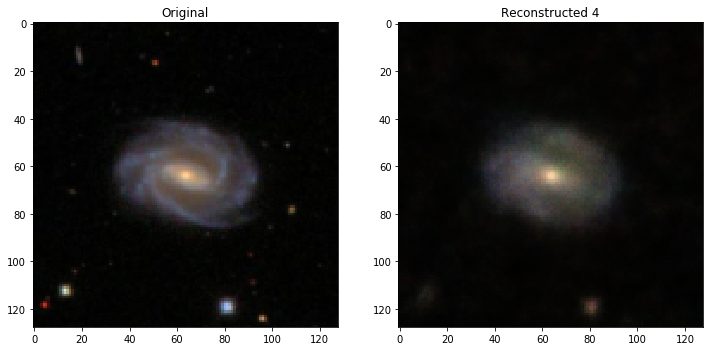

In [49]:
# Testing reconstruction
idx = np.random.randint(1, 8000)
org_img = train_dataset[idx][0]
pic = train_dataset.dataset.get_image(idx)
test, _,label = train_dataset[idx]
inputs = test.cuda()
rec, mu, var = fc_model(inputs[None])
rec = rec.view(-1, 3, 128, 128)
resp = rec.squeeze().permute(1, 2, 0).detach().cpu().numpy()

fig = plt.figure(figsize=(12,6))
fig.add_subplot(1, 2, 1)
plt.imshow(org_img.permute(1, 2, 0).numpy())
plt.title("Original")

fig.add_subplot(1, 2, 2)
plt.imshow(resp)
title = "Reconstructed " + str(label)
plt.title(title)

### 5.2.1 VAE Architecture 2: 5-layer convnet

Architecture 2 is very similar to architecture 0, the main addition being an extra convolutional layer on both the encoder and decoder side. As the model complexity increases, so do the number of trainable parameters. Given a noticeable performance improvement over architecture 0, architecture 2 was used as a platform to experiment with other decoding techniques, such as the addition of an auxiliary task to the deconding process (as explained in this [article](https://anotherdatum.com/vae2.html)). Knowledge of an image's label (i.e. class) during training allows us to train a classifier in-between the encoding and decoding process; the objective is to simultaneously learn to predict the correct label of the encoded image and decode it.

**Number of parameters**: 32829059

In [50]:
# Five convolutional layer VAE (architecture 2)
class ConvVAE(nn.Module):
    def __init__(self, input_channels=3, zdim=128, image_size=28):
        super(ConvVAE, self).__init__()
        self.z_dim = zdim
        self.img_size = image_size
        # encoder part
        self.encoder_conv1 = nn.Conv2d(input_channels, zdim//16, 3, stride=2, padding=1)
        self.encoder_bn1 = nn.BatchNorm2d(zdim//16)
        self.encoder_conv2 = nn.Conv2d(zdim//16, zdim//8, 3, stride=2, padding=1)
        self.encoder_bn2 = nn.BatchNorm2d(zdim//8)
        self.encoder_conv3 = nn.Conv2d(zdim//8, zdim//4, 3, stride=2, padding=1)
        self.encoder_bn3 = nn.BatchNorm2d(zdim//4)
        self.encoder_conv4 = nn.Conv2d(zdim//4, zdim//2, 3, stride=2, padding=1)
        self.encoder_bn4 = nn.BatchNorm2d(zdim//2)
        self.encoder_conv5 = nn.Conv2d(zdim//2, zdim, 3, stride=2, padding=1)
        self.encoder_bn5 = nn.BatchNorm2d(zdim)
        
        # bottleneck
        self.fc21 = nn.Linear(2048, zdim)
        self.fc22 = nn.Linear(2048, zdim)
        self.fc3 = nn.Linear(2*zdim, 2048)
                    
        # decoder part
        self.decoder_conv1 = nn.ConvTranspose2d(2048, zdim//2, kernel_size=7, stride=2)
        self.decoder_bn1 = nn.BatchNorm2d(zdim//2)
        self.decoder_conv2 = nn.ConvTranspose2d(zdim//2, zdim//4, kernel_size=3, stride=2)
        self.decoder_bn2 = nn.BatchNorm2d(zdim//4)
        self.decoder_conv3 = nn.ConvTranspose2d(zdim//4, zdim//8, kernel_size=3, stride=2)
        self.decoder_bn3 = nn.BatchNorm2d(zdim//8)
        self.decoder_conv4 = nn.ConvTranspose2d(zdim//8, zdim//16, kernel_size=3, stride=2)
        self.decoder_bn4 = nn.BatchNorm2d(zdim//16)
        self.decoder_conv5 = nn.ConvTranspose2d(zdim//16, input_channels, kernel_size=3, stride=2)
        self.sig = nn.Sigmoid()
        
        #digit classifier
        self.classifier = nn.Sequential(
            nn.Linear(49152, 512),
            nn.Sigmoid(),
            nn.Linear(512, 128)
        )
        
#         self.initialize_weights()
#         nn.init.constant_(self.fc22.weight, 0.00)
        

    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
#                 nn.init.xavier_normal_(m.weight)#, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

        
    def encode(self, x):
        x1 = F.leaky_relu(self.encoder_conv1(x), negative_slope=0.2)
        x2 = F.leaky_relu(self.encoder_conv2(x1), negative_slope=0.2)
        x3 = F.leaky_relu(self.encoder_conv3(x2), negative_slope=0.2)
        x3 = F.leaky_relu(self.encoder_conv4(x3), negative_slope=0.2)
        x4 = F.leaky_relu(self.encoder_conv5(x3), negative_slope=0.2)
        return self.fc21(x4.view(-1, 2048)), self.fc22(x4.view(-1, 2048))

        
    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        z1 = F.relu(self.decoder_conv1(h3.view(-1, 2048, 1, 1)))
    
        z2 = F.relu(self.decoder_conv2(z1))
        z3 = F.relu(self.decoder_conv3(z2))
        z4 = F.relu(self.decoder_conv4(z3))
        z5 = self.sig(F.interpolate(self.decoder_conv5(z4), 128, mode='bilinear', align_corners=True))
        return z5
        
    def reparameterize(self, mu, log_var):
        # we sample eps = N(0, 1) instead of Q(z|x)
        # z = z_means + exp(0.5 * z_log_var) * eps
        eps = torch.randn_like(mu)
        eps = eps.cuda()
        return mu + torch.exp(0.5 * log_var)*eps
    
    def get_latent_var(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return z
        
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        # Classification
        logits = self.classifier(x.view(-1, 49152))
        new_z = torch.cat((z, logits), axis=1)
        return self.decode(new_z), mu, logvar, logits


In [51]:
# Kernel weight visualization
# source: https://www.linkedin.com/pulse/custom-function-visualizing-kernel-weights-activations-arun-das
def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: 
        ax=plt.gca()
        l = ax.figure.subplotpars.left
        r = ax.figure.subplotpars.right
        t = ax.figure.subplotpars.top
        b = ax.figure.subplotpars.bottom
        figw = float(w)/(r-l)
        figh = float(h)/(t-b)
        ax.figure.set_size_inches(figw, figh)

def custom_viz(kernels, path=None, cols=None):
    """Visualize weight and activation matrices learned 
    during the optimization process. Works for any size of kernels.
    
    Arguments
    =========
    kernels: Weight or activation matrix. Must be a high dimensional
    Numpy array. Tensors will not work.
    path: Path to save the visualizations.
    cols: TODO: Number of columns (doesn't work completely yet.)
    
    Example
    =======
    kernels = model.conv1.weight.cpu().detach().clone()
    kernels = kernels - kernels.min()
    kernels = kernels / kernels.max()
    custom_viz(kernels, 'results/conv1_weights.png', 5)
    """
    
    N = kernels.shape[0]
    C = kernels.shape[1]

    Tot = N*C

    # If single channel kernel with HxW size,# plot them in a row.# Else, plot image with C number of columns.
    if C>1:
        columns = C
    elif cols==None:
        columns = N
    elif cols:
        columns = cols
    rows = Tot // columns 
    rows += Tot % columns

    pos = range(1,Tot + 1)

    fig = plt.figure()
    fig.tight_layout()
    k=0
    for i in range(kernels.shape[0]):
        for j in range(kernels.shape[1]):
            img = kernels[i][j]
            ax = fig.add_subplot(rows,columns,pos[k])
            ax.imshow(img, cmap='gray')
            plt.axis('off')
            k = k+1

    set_size(30,30,ax)
    if path:
        plt.savefig(path, dpi=100)

Despite having the higher complexity with the introduction of 5 convolutional layers in both the encoder and the decoder, the results from ConvVAE are inferior to the FC results, mostly due to the blurriness which tarnishes some of the features. As seen in the following figure, the suboptimal training process may be the reason for the lower quality reconstructions; as the KL loss seems to have too big a weight, the total loss ends up being affected.

![conv_training](./convnet/losses.png)

Nonetheless, the following reconstructions and latent space visualization are still acceptable. Improving the training and increasing the number of epochs may improve the overall results for this model. The spiral galaxy is a good example showing the limitations of the model, as fainter features are not captured in the reconstruction. This model was used to experiment with an auxiliary task to learn to classify galaxies as well, thus helping to balance the different losses. Unfortunately, the results do not suggest this addition has improved the classification or the organization fo the latent space. In the future, a closer look at the implementation would be useful to determine if the different losses are computed and weighted correctly.

![conv_sample0](./convnet/sample0.png)
![conv_sample1](./convnet/sample1.png)
![conv_sample2](./convnet/sample2.png)
![conv_sample3](./convnet/sample3.png)
![conv_sample4](./convnet/sample4.png)
![conv_sample5](./convnet/sample5.png)
![conv_tnse](./convnet/tsne_last.png)

The labels in the above plot correspond to the reconstruction labels in the images above. We again see gradual improvements in the latent visualization with tsne; the comments about class distinction mentionned above still apply.

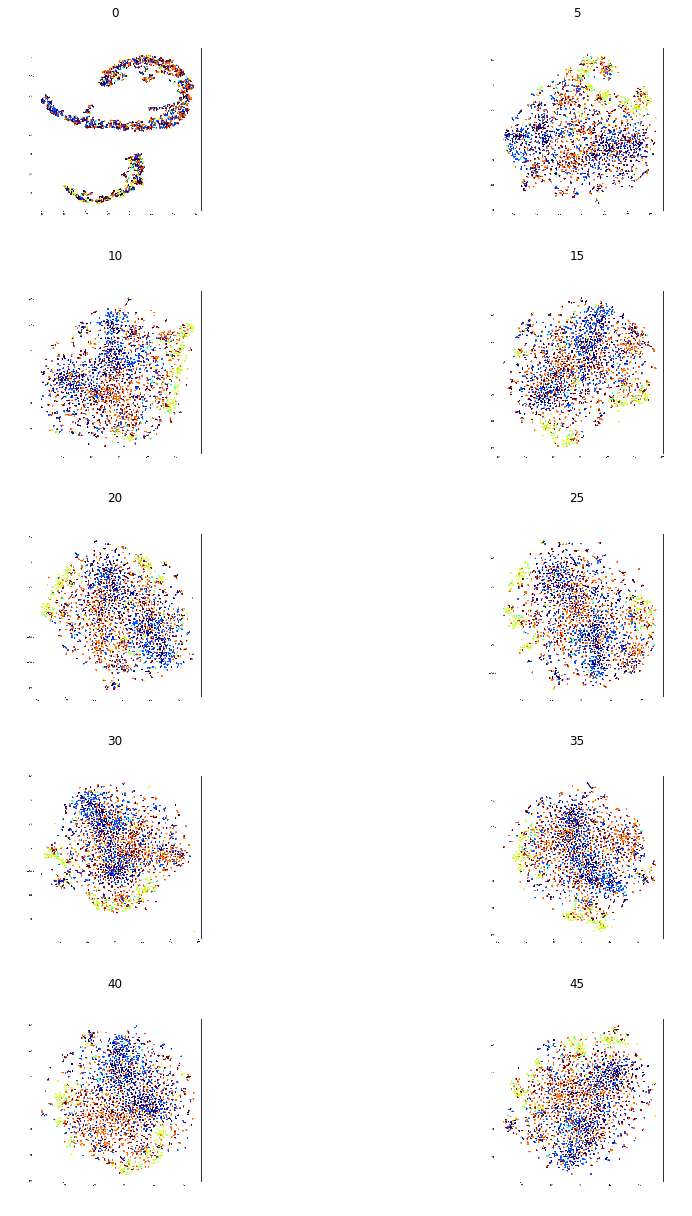

In [52]:
fig = plt.figure(figsize=(17, 17))
ax = [plt.subplot(5,2,i+1) for i in range(10)]
filenames = ["./convnet/tsne000.png", "./convnet/tsne005.png", "./convnet/tsne010.png", "./convnet/tsne015.png", "./convnet/tsne020.png",
            "./convnet/tsne025.png", "./convnet/tsne030.png", "./convnet/tsne035.png", "./convnet/tsne040.png", "./convnet/tsne045.png"]
for i, a in enumerate(ax):
    img = plt.imread(filenames[i])
    a.imshow(img)
    a.set_title(str(5*i))
    a.axis('off')

plt.subplots_adjust(wspace=0.00001, hspace=0.0001)
plt.tight_layout()

#### Testing saved ConvNet model

In [53]:
# Loading the model for inference
conv_model = ConvVAE(input_channels=3, image_size=128, zdim=128)
conv_model.load_state_dict(torch.load("./convnet/convnet_ep73.path"))
conv_model = conv_model.cuda()
conv_model.eval()

ConvVAE(
  (encoder_conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (encoder_bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (encoder_conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (encoder_bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (encoder_conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (encoder_bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (encoder_conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (encoder_bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (encoder_conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (encoder_bn5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc21): Linear(in_features=2048, out_features=128, bias=True)
  (fc22): Linear(in

##### Conv layer visualization

(-0.5, 599.5, 399.5, -0.5)

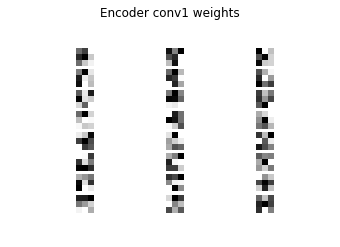

In [54]:
# Visualizing kernel weights
# kernels = conv_model.encoder_conv1.weight.cpu().detach().clone()
# kernels = kernels - kernels.min()
# kernels = kernels / kernels.max()
# custom_viz(kernels, './convnet/encoder_conv1_weights.png')
fig = plt.figure()
enc_conv1 = plt.imread('./convnet/encoder_conv1_weights.png')
plt.imshow(enc_conv1)
plt.title('Encoder conv1 weights')
plt.axis('off')

(-0.5, 599.5, 399.5, -0.5)

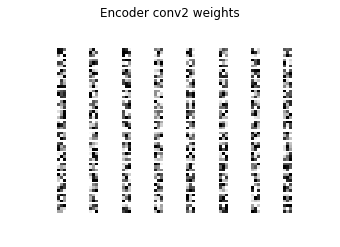

In [55]:
# kernels = conv_model.encoder_conv2.weight.cpu().detach().clone()
# kernels = kernels - kernels.min()
# kernels = kernels / kernels.max()
# custom_viz(kernels, './convnet/encoder_conv2_weights.png')
fig = plt.figure()
enc_conv2 = plt.imread('./convnet/encoder_conv2_weights.png')
plt.imshow(enc_conv2)
plt.title('Encoder conv2 weights')
plt.axis('off')

(-0.5, 599.5, 399.5, -0.5)

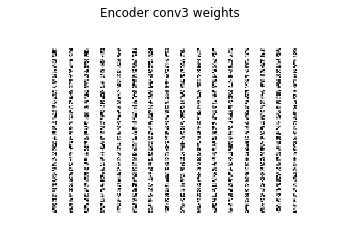

In [56]:
# kernels = conv_model.encoder_conv3.weight.cpu().detach().clone()
# kernels = kernels - kernels.min()
# kernels = kernels / kernels.max()
# custom_viz(kernels, './convnet/encoder_conv3_weights.png')
fig = plt.figure()
enc_conv3 = plt.imread('./convnet/encoder_conv3_weights.png')
plt.imshow(enc_conv3)
plt.title('Encoder conv3 weights')
plt.axis('off')

(-0.5, 599.5, 399.5, -0.5)

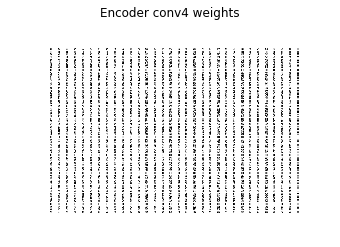

In [57]:
# kernels = conv_model.encoder_conv4.weight.cpu().detach().clone()
# kernels = kernels - kernels.min()
# kernels = kernels / kernels.max()
# custom_viz(kernels, './convnet/encoder_conv4_weights.png')
fig = plt.figure()
enc_conv4 = plt.imread('./convnet/encoder_conv4_weights.png')
plt.imshow(enc_conv4)
plt.title('Encoder conv4 weights')
plt.axis('off')

**NOTE**: unfortunately, computing the kernel visualization for the fifth encoder layer and the first deconv layer proved to be too computationally expensive on CPU

(-0.5, 599.5, 399.5, -0.5)

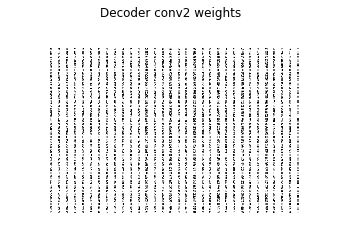

In [58]:
# kernels = conv_model.decoder_conv2.weight.cpu().detach().clone()
# kernels = kernels - kernels.min()
# kernels = kernels / kernels.max()
# custom_viz(kernels, './convnet/decoder_conv2_weights.png')
fig = plt.figure()
dec_conv2 = plt.imread('./convnet/decoder_conv2_weights.png')
plt.imshow(dec_conv2)
plt.title('Decoder conv2 weights')
plt.axis('off')

(-0.5, 599.5, 399.5, -0.5)

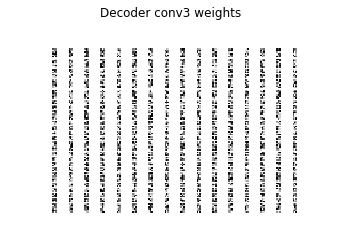

In [59]:
# kernels = conv_model.decoder_conv3.weight.cpu().detach().clone()
# kernels = kernels - kernels.min()
# kernels = kernels / kernels.max()
# custom_viz(kernels, './convnet/decoder_conv3_weights.png')
fig = plt.figure()
dec_conv3 = plt.imread('./convnet/decoder_conv3_weights.png')
plt.imshow(dec_conv3)
plt.title('Decoder conv3 weights')
plt.axis('off')

(-0.5, 599.5, 399.5, -0.5)

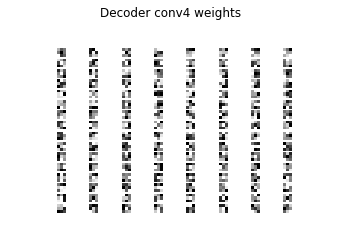

In [60]:
# kernels = conv_model.decoder_conv4.weight.cpu().detach().clone()
# kernels = kernels - kernels.min()
# kernels = kernels / kernels.max()
# custom_viz(kernels, './convnet/decoder_conv4_weights.png')
fig = plt.figure()
dec_conv4 = plt.imread('./convnet/decoder_conv4_weights.png')
plt.imshow(dec_conv4)
plt.title('Decoder conv4 weights')
plt.axis('off')

(-0.5, 599.5, 399.5, -0.5)

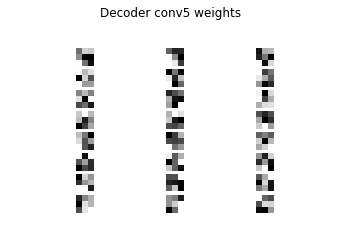

In [61]:
# kernels = conv_model.decoder_conv5.weight.cpu().detach().clone()
# kernels = kernels - kernels.min()
# kernels = kernels / kernels.max()
# custom_viz(kernels, './convnet/decoder_conv5_weights.png')
fig = plt.figure()
dec_conv5 = plt.imread('./convnet/decoder_conv5_weights.png')
plt.imshow(dec_conv5)
plt.title('Decoder conv5 weights')
plt.axis('off')

Text(0.5, 1.0, 'Reconstructed 2')

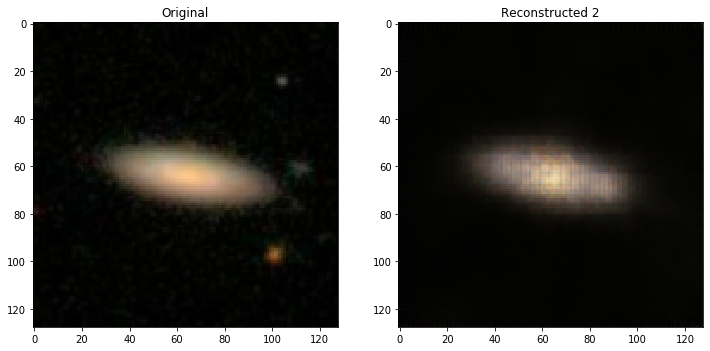

In [67]:
# Testing reconstruction
idx = np.random.randint(1, 8000)
org_img = train_dataset[idx][0]
pic = train_dataset.dataset.get_image(idx)
test, _,label = train_dataset[idx]
inputs = test.cuda()
rec, mu, var, _ = conv_model(inputs[None])
rec = rec.view(-1, 3, 128, 128)
resp = rec.squeeze().permute(1, 2, 0).detach().cpu().numpy()

fig = plt.figure(figsize=(12,6))
fig.add_subplot(1, 2, 1)
plt.imshow(org_img.permute(1, 2, 0).numpy())
plt.title("Original")

fig.add_subplot(1, 2, 2)
plt.imshow(resp)
title = "Reconstructed " + str(label)
plt.title(title)

### 5.2.1 VAE Architecture 3: 5-block ResNet

The third architecture incorporates ResNet basic blocks in the encoding and decoding process in a manner similar to the one found in the Appendix B of "Variational Lossy Autoencoder", Chen et al. ([source 3](https://arxiv.org/pdf/1611.02731.pdf))

**Number of parameters**: 23222147

In [68]:
class ResNetBlock(nn.Module):
    def __init__(self, inplanes, planes, stride=1, padding=1, bias=False):
        super(ResNetBlock, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride, padding=padding, bias=bias)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=padding, bias=bias)
        self.bn2 = nn.BatchNorm2d(planes)
    
    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        
        # residual connection
        out += identity
        out = self.relu(out)
        return out

In [69]:
# ResNet VAE (architecture 3)
class ResNetVAE(nn.Module):
    def __init__(self, input_channels=3, zdim=128, image_size=28):
        super(ResNetVAE, self).__init__()
        self.z_dim = zdim
        self.img_size = image_size
        
        #starter
        self.starter = nn.Sequential(
            nn.Conv2d(input_channels, 32, 7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        
        # encoder
        self.block1 = ResNetBlock(32, 32)
        self.block2 = ResNetBlock(32, 32)
        self.conv1 = nn.Conv2d(32, 64, 3, stride=2)
        self.block3 = ResNetBlock(64, 64)
        self.block4 = ResNetBlock(64, 64)
        self.conv2 = nn.Conv2d(64, 128, 3, stride=2)
        self.block5 = ResNetBlock(128, 128)
        self.block6 = ResNetBlock(128, 128)
        self.block7 = ResNetBlock(128, 128)
        self.conv3 = nn.Conv2d(128, 64, kernel_size=1)
        
        # bottleneck
        self.fc11 = nn.Linear(3136, zdim)
        self.fc12 = nn.Linear(3136, zdim)
        self.fc3 = nn.Linear(zdim, 3136)
        
        # decoder
        self.conv4 = nn.ConvTranspose2d(3136, 128, kernel_size=7, stride=2, output_padding=1)
        self.block8 = ResNetBlock(128, 128)
        self.block9 = ResNetBlock(128, 128)
        self.block10 = ResNetBlock(128, 128)
        self.conv5 = nn.ConvTranspose2d(128, 64, 3, stride=2, output_padding=1, padding=1)
        self.block11 = ResNetBlock(64, 64)
        self.block12 = ResNetBlock(64, 64)
        self.conv6 = nn.ConvTranspose2d(64, 32, 3, stride=2, output_padding=1, padding=1)
        self.block13 = ResNetBlock(32, 32)
        self.block14 = ResNetBlock(32, 32)
        self.conv7 = nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=1, padding=1)
        self.conv8 = nn.ConvTranspose2d(16, 3, 3, stride=2, output_padding=1, padding=1)
        self.sig = nn.Sigmoid()
        
#         self.initialize_weights()
#         nn.init.constant_(self.fc22.weight, 0.00)
        

    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
#                 nn.init.xavier_normal_(m.weight)#, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

        
    def encode(self, x):
        out = self.starter(x)
        out = self.block1(out)
        out = self.block2(out)
        out = F.relu(self.conv1(out))
        out = self.block3(out)
        out = self.block4(out)
        out = F.relu(self.conv2(out))
        out = self.block5(out)
        out = self.block6(out)
        out = self.block7(out)
        out = self.conv3(out)
        return self.fc11(out.view(-1, 3136)), self.fc12(out.view(-1, 3136))

         
    def decode(self, z):
        out = F.relu(self.fc3(z))
        out = F.relu(self.conv4(out.view(-1, 3136, 1, 1)))
        out = self.block8(out)
        out = self.block9(out)
        out = self.block10(out)
        out = F.relu(self.conv5(out))
        out = self.block11(out)
        out = self.block12(out)
        out = F.relu(self.conv6(out))
        out = self.block13(out)
        out = self.block14(out)
        out = F.relu(self.conv7(out))
        out = self.sig(self.conv8(out))
        return out
        
    def reparameterize(self, mu, log_var):
        # we sample eps = N(0, 1) instead of Q(z|x)
        # z = z_means + exp(0.5 * z_log_var) * eps
        eps = torch.randn_like(mu)
        eps = eps.cuda()
        return mu + torch.exp(0.5 * log_var)*eps
    
    def get_latent_var(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return z
        
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


A similar comment as the one for the ConvVAE can be made about the ResNetVAE. The results did not significantly benefit from the added complexity introduced by the additional ResNet blocks. The results are similar to those of ConvVAE.

![resnet_training](./resnet/training.png)

While the reconstructions appear to be blurry, the spiral-shaped reconstruction suggests that results would improve with additional training epochs (these results are obtained after 50 epochs).

![resnet_sample0](./resnet/sample0.png)
![resnet_sample1](./resnet/sample1.png)
![resnet_sample2](./resnet/sample2.png)
![resnet_sample3](./resnet/sample3.png)
![resnet_sample4](./resnet/sample4.png)
![resnet_sample5](./resnet/sample5.png)
![resnet_tnse](./resnet/tsne_last.png)

The labels in the above plot correspond to the reconstruction labels in the images above. Finally, we again see gradual improvements in the latent visualization with tsne; the comments about class distinction mentionned above still apply. The latent space visualization would improve if the class distinction was better defined. This can be achieved by introducing additional classes.

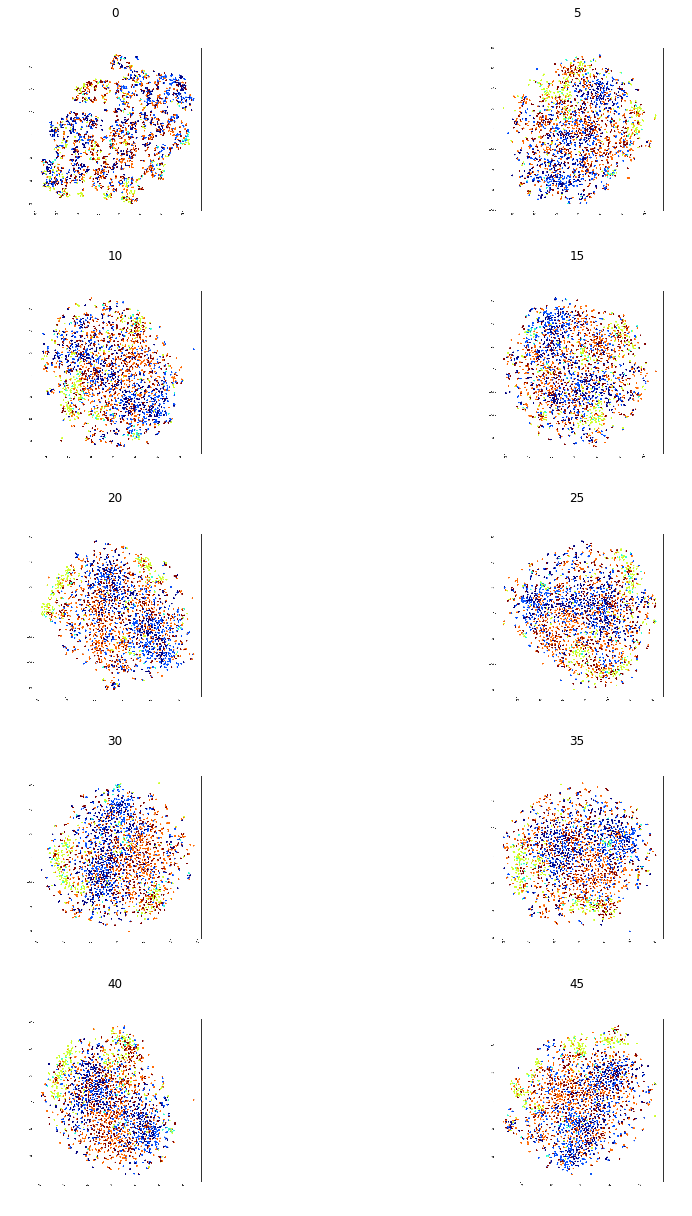

In [70]:
fig = plt.figure(figsize=(17, 17))
ax = [plt.subplot(5,2,i+1) for i in range(10)]
filenames = ["./resnet/tsne000.png", "./resnet/tsne005.png", "./resnet/tsne010.png", "./resnet/tsne015.png", "./convnet/tsne020.png",
            "./resnet/tsne025.png", "./resnet/tsne030.png", "./resnet/tsne035.png", "./resnet/tsne040.png", "./convnet/tsne045.png"]
for i, a in enumerate(ax):
    img = plt.imread(filenames[i])
    a.imshow(img)
    a.set_title(str(5*i))
    a.axis('off')

plt.subplots_adjust(wspace=0.00001, hspace=0.0001)
plt.tight_layout()

#### Testing saved ResNetVAE model

In [71]:
# Loading the model for inference
resnet_model = ResNetVAE(input_channels=3, image_size=128, zdim=128)
resnet_model.load_state_dict(torch.load("./resnet/resnet_ep050.path"))
resnet_model = resnet_model.cuda()
resnet_model.eval()

ResNetVAE(
  (starter): Sequential(
    (0): Conv2d(3, 32, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (block1): ResNetBlock(
    (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (block2): ResNetBlock(
    (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2)

##### Conv layer visualization
**NOTE**: only the intermediary conv layers will be visualized, not the ResNet block conv layers

(-0.5, 599.5, 399.5, -0.5)

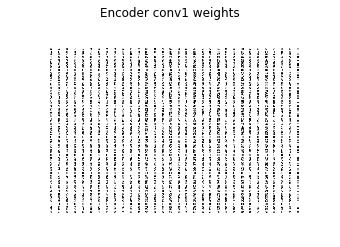

In [72]:
# Visualizing kernel weights
# kernels = resnet_model.conv1.weight.cpu().detach().clone()
# kernels = kernels - kernels.min()
# kernels = kernels / kernels.max()
# custom_viz(kernels, './resnet/resnet_conv1_weights.png')
fig = plt.figure()
conv1 = plt.imread('./resnet/resnet_conv1_weights.png')
plt.imshow(conv1)
plt.title('Encoder conv1 weights')
plt.axis('off')

**NOTE**: unfortunately, computing the weights for encoder layers conv2, conv3 and decoder layers conv 4, conv5 proved to be too computationally expensive on CPU

In [73]:
# kernels = resnet_model.conv2.weight.cpu().detach().clone()
# kernels = kernels - kernels.min()
# kernels = kernels / kernels.max()
# custom_viz(kernels, './resnet/resnet_conv2_weights.png')
# fig = plt.figure()
# conv2 = plt.imread('./resnet/resnet_conv2_weights.png')
# plt.imshow(conv2)
# plt.title('Encoder conv2 weights')
# plt.axis('off')

In [74]:
# kernels = resnet_model.conv3.weight.cpu().detach().clone()
# kernels = kernels - kernels.min()
# kernels = kernels / kernels.max()
# custom_viz(kernels, './resnet/resnet_conv3_weights.png')
# fig = plt.figure()
# conv3 = plt.imread('./resnet/resnet_conv3_weights.png')
# plt.imshow(conv3)
# plt.title('Encoder conv3 weights')
# plt.axis('off')

In [75]:
# kernels = resnet_model.conv4.weight.cpu().detach().clone()
# kernels = kernels - kernels.min()
# kernels = kernels / kernels.max()
# custom_viz(kernels, './resnet/resnet_conv4_weights.png')
# fig = plt.figure()
# conv4 = plt.imread('./resnet/resnet_conv4_weights.png')
# plt.imshow(conv4)
# plt.title('Decoder conv4 weights')
# plt.axis('off')

In [76]:
# kernels = resnet_model.conv5.weight.cpu().detach().clone()
# kernels = kernels - kernels.min()
# kernels = kernels / kernels.max()
# custom_viz(kernels, './resnet/resnet_conv5_weights.png')
# fig = plt.figure()
# conv5 = plt.imread('./resnet/resnet_conv5_weights.png')
# plt.imshow(conv5)
# plt.title('Decoder conv5 weights')
# plt.axis('off')

(-0.5, 599.5, 399.5, -0.5)

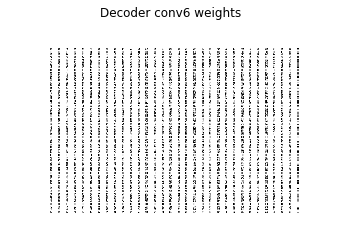

In [77]:
# kernels = resnet_model.conv6.weight.cpu().detach().clone()
# kernels = kernels - kernels.min()
# kernels = kernels / kernels.max()
# custom_viz(kernels, './resnet/resnet_conv6_weights.png')
fig = plt.figure()
conv6 = plt.imread('./resnet/resnet_conv6_weights.png')
plt.imshow(conv6)
plt.title('Decoder conv6 weights')
plt.axis('off')

(-0.5, 599.5, 399.5, -0.5)

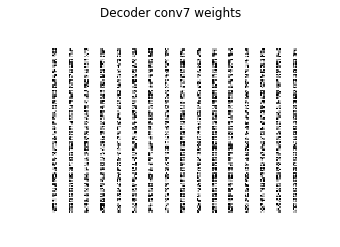

In [78]:
# kernels = resnet_model.conv7.weight.cpu().detach().clone()
# kernels = kernels - kernels.min()
# kernels = kernels / kernels.max()
# custom_viz(kernels, './resnet/resnet_conv7_weights.png')
fig = plt.figure()
conv7 = plt.imread('./resnet/resnet_conv7_weights.png')
plt.imshow(conv7)
plt.title('Decoder conv7 weights')
plt.axis('off')

(-0.5, 599.5, 399.5, -0.5)

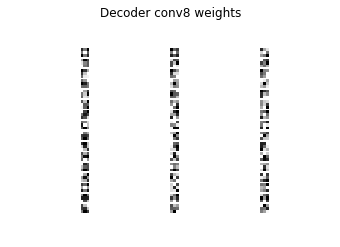

In [79]:
# kernels = resnet_model.conv8.weight.cpu().detach().clone()
# kernels = kernels - kernels.min()
# kernels = kernels / kernels.max()
# custom_viz(kernels, './resnet/resnet_conv8_weights.png')
fig = plt.figure()
conv8 = plt.imread('./resnet/resnet_conv8_weights.png')
plt.imshow(conv8)
plt.title('Decoder conv8 weights')
plt.axis('off')

Text(0.5, 1.0, 'Reconstructed 4')

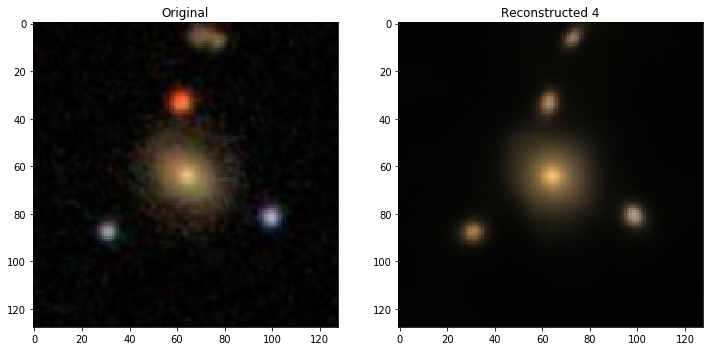

In [80]:
# Testing reconstruction
idx = np.random.randint(1, 8000)
org_img = train_dataset[idx][0]
pic = train_dataset.dataset.get_image(idx)
test, _,label = train_dataset[idx]
inputs = test.cuda()
rec, mu, var = resnet_model(inputs[None])
rec = rec.view(-1, 3, 128, 128)
resp = rec.squeeze().permute(1, 2, 0).detach().cpu().numpy()

fig = plt.figure(figsize=(12,6))
fig.add_subplot(1, 2, 1)
plt.imshow(org_img.permute(1, 2, 0).numpy())
plt.title("Original")

fig.add_subplot(1, 2, 2)
plt.imshow(resp)
title = "Reconstructed " + str(label)
plt.title(title)

**NOTE**: below is the code used to train/test the various networks as well as to generate the various plots seen above

In [81]:
# Models

# Architecture 0
# model = VAE(input_channels=3, image_size=128, zdim=128)
# model = model.cuda()
# model_type = 0

# Architecture 1
model = FcVAE(input_channels=3, image_size=128, hdim=512)
model = model.cuda()
model_type = 1

# Architecture 2
# model = ConvVAE(input_channels=3, image_size=128, zdim=128)
# model = model.cuda()
# model_type = 2

# Architecture 3
# model = ResNetVAE(input_channels=3, image_size=128, zdim=128)
# model.cuda()
# model_type = 3

# Training
# criterion = nn.BCELoss()
# criterion.size_average = False
# criterion = nn.MSELoss()
# criterion = criterion.cuda()
criterion = None

# optimizer = torch.optim.RMSprop(model.parameters())
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

In [82]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [83]:
print("Number of trainable parameters: {}".format(count_parameters(model)))

Number of trainable parameters: 75547648


In [84]:
# Training VAE
# ConvNet
# def loss_function(recon_x, x, mu, logvar, criterion=None):
#     BCE = F.binary_cross_entropy(recon_x, x, reduction='mean')
#     BCE *= 10
#     KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
#     KLD /= 1000
#     return BCE, 0.1*KLD

# FcNet
def loss_function(recon_x, x, mu, logvar, criterion=None):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='mean')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    KLD /= (128 * 128 * 3)
    return BCE, 0.01*KLD

# ResNet
# def loss_function(recon_x, x, mu, logvar, criterion=None):
#     BCE = F.binary_cross_entropy(recon_x, x, reduction='mean')
#     KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
#     KLD /= (128 * 128 * 3)
#     return BCE, 0.01*KLD
 
    
def training(train_loader, model, optimizer, criterion, loss_graph, kl_graph, class_graph, kl=False, model_type=0):
    
    epoch_loss = 0
    model.train()

    for i, batch in enumerate(train_loader):
        inputs, _, label = batch
        if USE_GPU:
            inputs = inputs.cuda()
            model = model.cuda()
            label = label.cuda()
            
        optimizer.zero_grad()
        
        if model_type == 2:
            rec_x, mu, logvar, logits = model(inputs)
        else:
            rec_x, mu, logvar = model(inputs)
        
        if model_type == 1:
            rec_x = rec_x.view(-1, 3, 128, 128)
        elif model_type == 2:
            # Classification loss
            probs = F.log_softmax(logits, dim=1)
            class_loss = F.nll_loss(probs, label, reduction='mean').item()
            class_graph.append(class_loss)
#                 pred = probs.argmax(dim=1, keepdim=True)


        rec_loss, kl_loss = loss_function(rec_x,inputs,mu,logvar)   
    
        # "Warm up" the KL loss
        if not kl:
            kl_loss = 0.0
            kl_graph.append(kl_loss)
        else:
            kl_loss = kl_loss.item()
            kl_graph.append(kl_loss)
        loss_graph.append(rec_loss.item())
        
        if model_type == 2:
            loss = 1/1. * (rec_loss + kl_loss) + class_loss
        else:
            loss = 1/32.*(rec_loss + kl_loss)
            
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        
        if i % 1000 == 0:
            print("Training loss: rec: {}, kl: {}".format(rec_loss.item(), kl_loss))

    return epoch_loss / len(train_loader)

def evaluate(val_loader, model, criterion, loss_graph, kl_graph, class_graph, embeddings, labels, epoch, model_type=0):
    
    epoch_loss = 0
    model.eval()
    with torch.no_grad():
        for i, batch in enumerate(val_loader):
            inputs, _, label = batch
            if USE_GPU:
                inputs = inputs.cuda()
                model = model.cuda()
                label = label.cuda()

            if model_type == 2:
                rec_x, mu, logvar, logits = model(inputs)
            else:
                rec_x, mu, logvar = model(inputs)

            if model_type == 1:
                rec_x = rec_x.view(-1, 3, 128, 128)
            elif model_type == 2:
                # Classification loss
                probs = F.log_softmax(logits, dim=1)
#                 print(probs)
                class_loss = F.nll_loss(probs, label, reduction='mean').item()
                class_graph.append(class_loss)
#                 print("Classification loss: {}".format(class_loss))
#                 pred = probs.argmax(dim=1, keepdim=True)
                
                
            rec_loss, kl_loss = loss_function(rec_x,inputs,mu,logvar)   
    
            if model_type == 2:
                loss = 1/1. * (rec_loss + kl_loss) + class_loss
            else:
                loss = 1/32.*(rec_loss + kl_loss)
        
            loss_graph.append(loss.item())
            kl_graph.append(kl_loss.item())
              
            epoch_loss += loss.item()
            
            if epoch % 5 == 0: # periodically record embeddings for latent space visualization
                embeddings.append(mu.cpu().numpy())
                labels.append(label.cpu().numpy())
                
            if i % 1000 == 0:
                print("Testing loss: rec: {}, kl: {}".format(rec_loss.item(), kl_loss.item()))

    return epoch_loss / len(val_loader)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.53 µs


<IPython.core.display.Javascript object>


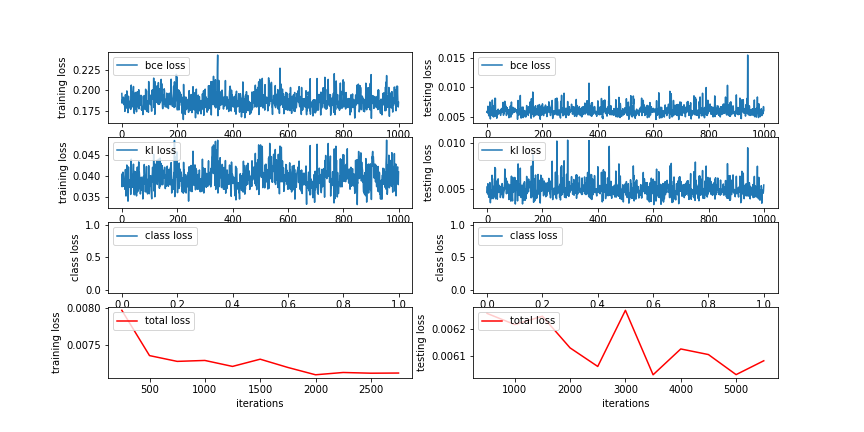

<IPython.core.display.Javascript object>


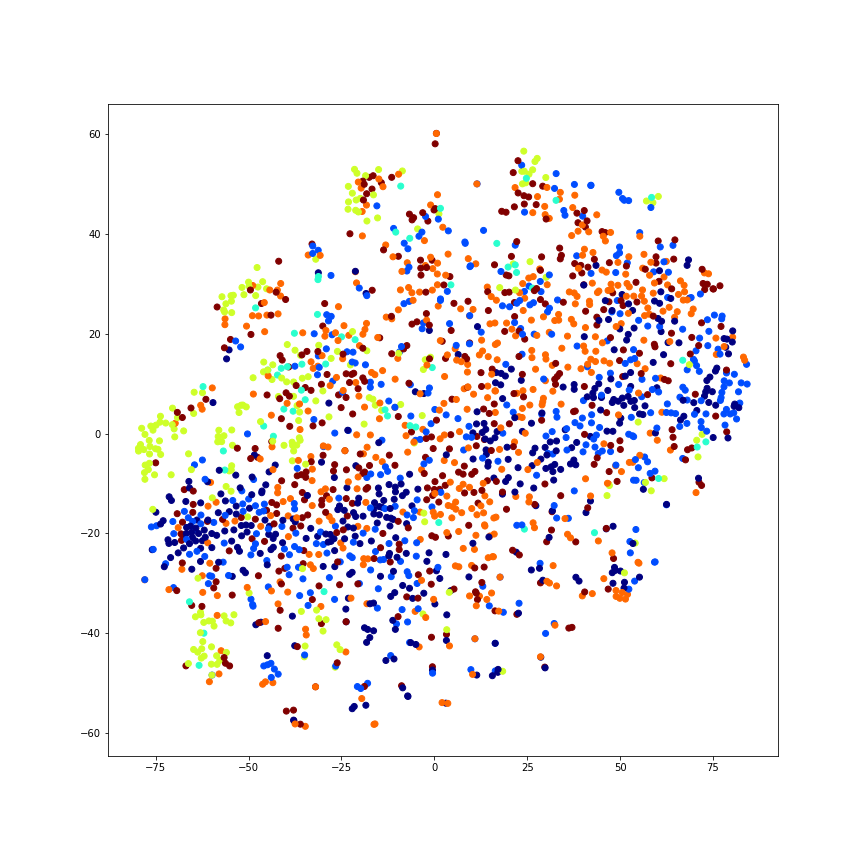

Training loss: rec: 0.7337541580200195, kl: 1.1570572496566456e-05
Testing loss: rec: 0.18244536221027374, kl: 0.00497468002140522
Epoch: 01 	Average losses: train:0.008 test:0.006
Training loss: rec: 0.2125329226255417, kl: 0.04191906750202179
Testing loss: rec: 0.18064798414707184, kl: 0.005077147390693426
Epoch: 02 	Average losses: train:0.007 test:0.006
Training loss: rec: 0.1881009191274643, kl: 0.039102520793676376
Testing loss: rec: 0.17956191301345825, kl: 0.004994023125618696
Epoch: 03 	Average losses: train:0.007 test:0.006
Training loss: rec: 0.20519380271434784, kl: 0.04493613913655281
Testing loss: rec: 0.18047408759593964, kl: 0.00502479262650013
Epoch: 04 	Average losses: train:0.007 test:0.006
Training loss: rec: 0.18378907442092896, kl: 0.039803531020879745
Testing loss: rec: 0.1801176816225052, kl: 0.004631710704416037
Epoch: 05 	Average losses: train:0.007 test:0.006
Training loss: rec: 0.18805356323719025, kl: 0.03898392245173454
Testing loss: rec: 0.183051049709320

<IPython.core.display.Javascript object>


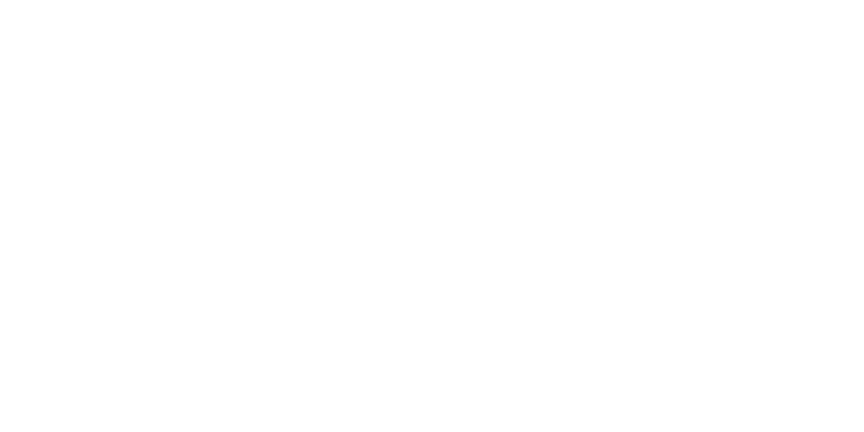

<IPython.core.display.Javascript object>


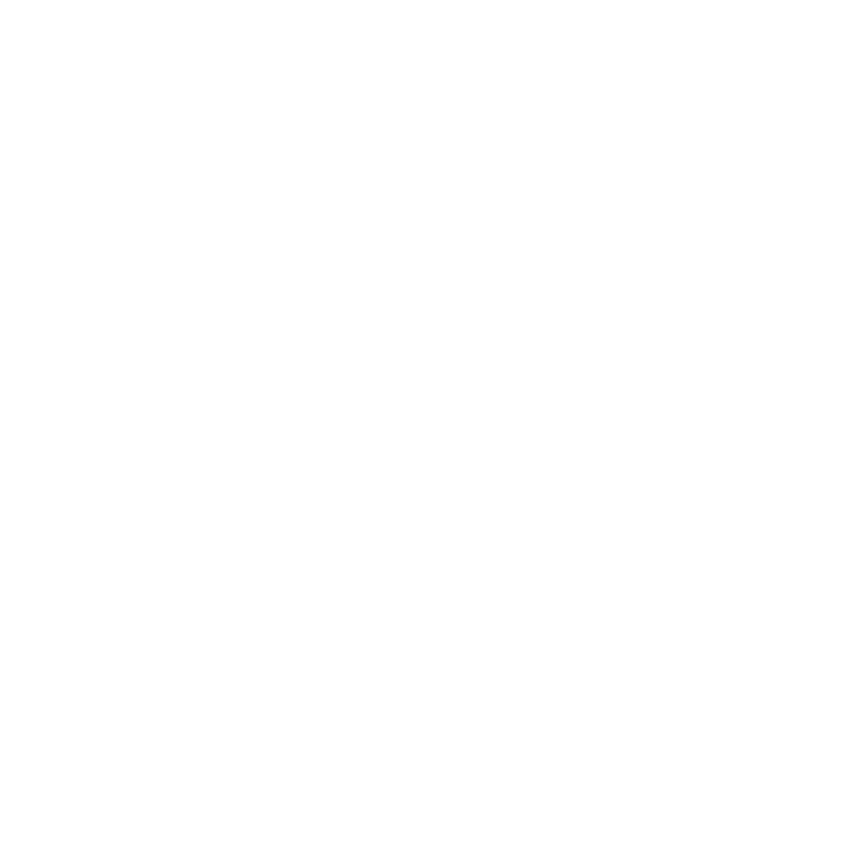

In [85]:
%time
%matplotlib notebook

# TODO: train with more samples (more epochs?)
N_EPOCHS = 11

loss_graph_train = []
kl_graph_train = []
loss_graph_test = []
kl_graph_test = []
class_graph_train = []
class_graph_test = []
avg_loss_train = []
avg_loss_test = []

# Training/test losses
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(4,2,1)
ax4 = fig.add_subplot(4,2,2)
ax2 = fig.add_subplot(4,2,3)
ax5 = fig.add_subplot(4,2,4)
ax8 = fig.add_subplot(4,2,5)
ax9 = fig.add_subplot(4,2,6)
ax3 = fig.add_subplot(4,2,7)
ax6 = fig.add_subplot(4,2,8)


# Latent space visualization
fig2 = plt.figure(figsize=(12, 12))
ax7 = fig2.add_subplot(1, 1, 1)

tsne = TSNE(n_components=2, perplexity=25, n_iter=5000, init='random', random_state=7)

kl = False
linear = True

for epoch in range(N_EPOCHS):
    if epoch >= 0 and not kl:
        kl = True
    # Latent space visualization
    embed = []
    labels = []
    
    train_loss = training(train_loader, model, optimizer, criterion, loss_graph_train, kl_graph_train, class_graph_train, kl, model_type=model_type)
    test_loss = evaluate(test_loader, model, criterion, loss_graph_test, kl_graph_test, class_graph_test, embed, labels, epoch, model_type=model_type)
        
    avg_loss_train.append((len(loss_graph_train), train_loss))
    avg_loss_test.append((len(loss_graph_test), test_loss))
    
    # TRAINING
    window_idx = 1000
    ax1.clear()
    ax1.set_xlabel('iterations')
    ax1.set_ylabel('training loss')
    ax1.plot(loss_graph_train[-window_idx:], label='bce loss')
    ax1.legend(loc='upper left')
    
    ax2.clear()
    ax2.set_xlabel('iterations')
    ax2.set_ylabel('training loss')
    ax2.plot(kl_graph_train[-window_idx:], label='kl loss')
    ax2.legend(loc='upper left')
    
    ax8.clear()
    ax8.set_xlabel('iterations')
    ax8.set_ylabel('class loss')
    ax8.plot(class_graph_train[-window_idx:], label='class loss')
    ax8.legend(loc='upper left')
    
    ax3.clear()
    ax3.set_xlabel('iterations')
    ax3.set_ylabel('training loss')
    ax3.plot(*zip(*avg_loss_train), label='total loss', color='red')
    ax3.legend(loc='upper left')
    
    # EVALUATING
    
    ax4.clear()
    ax4.set_xlabel('iterations')
    ax4.set_ylabel('testing loss')
    ax4.plot(loss_graph_test[-window_idx:], label='bce loss')
    ax4.legend(loc='upper left')
    
    ax5.clear()
    ax5.set_xlabel('iterations')
    ax5.set_ylabel('testing loss')
    ax5.plot(kl_graph_test[-window_idx:], label='kl loss')
    ax5.legend(loc='upper left')
    
    ax9.clear()
    ax9.set_xlabel('iterations')
    ax9.set_ylabel('class loss')
    ax9.plot(class_graph_test[-window_idx:], label='class loss')
    ax9.legend(loc='upper left')
    
    ax6.clear()
    ax6.set_xlabel('iterations')
    ax6.set_ylabel('testing loss')
    ax6.plot(*zip(*avg_loss_test), label='total loss', color='red')
    ax6.legend(loc='upper left')
    fig.canvas.draw()
    
    # Latent space visualization
    if epoch % 5 == 0:
#         fig2.clf()
        ax7.clear()
        embeddings = np.array(embed)
        embeddings = embeddings.reshape((embeddings.shape[0]*embeddings.shape[1], embeddings.shape[-1]))
        classes = np.array(labels).flatten()
        data2d = tsne.fit_transform(embeddings)
        latent = ax7.scatter(data2d[:,0],data2d[:,1], c=classes, cmap='jet')
        fig2.canvas.draw()
        fig2.savefig(str('tsne%03d'%epoch)+'.png')

    print(f'Epoch: {epoch+1:02} \tAverage losses: train:{train_loss:.3f} test:{test_loss:.3f}')
fig2.colorbar(latent)

In [45]:
# torch.save(model.state_dict(), str('convnet_ep%03d'%epoch)+'.path')

<IPython.core.display.Javascript object>


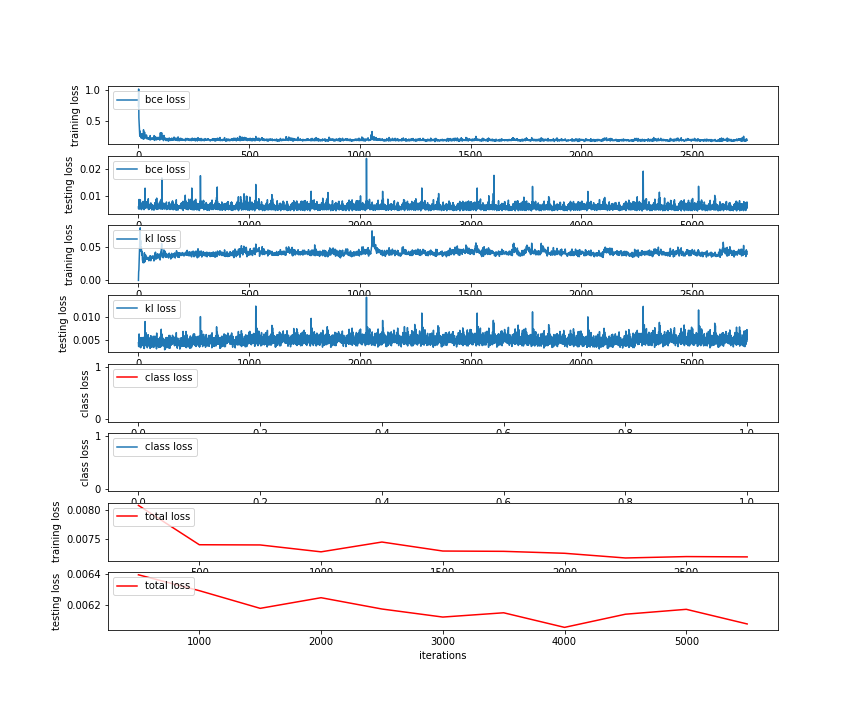

<IPython.core.display.Javascript object>


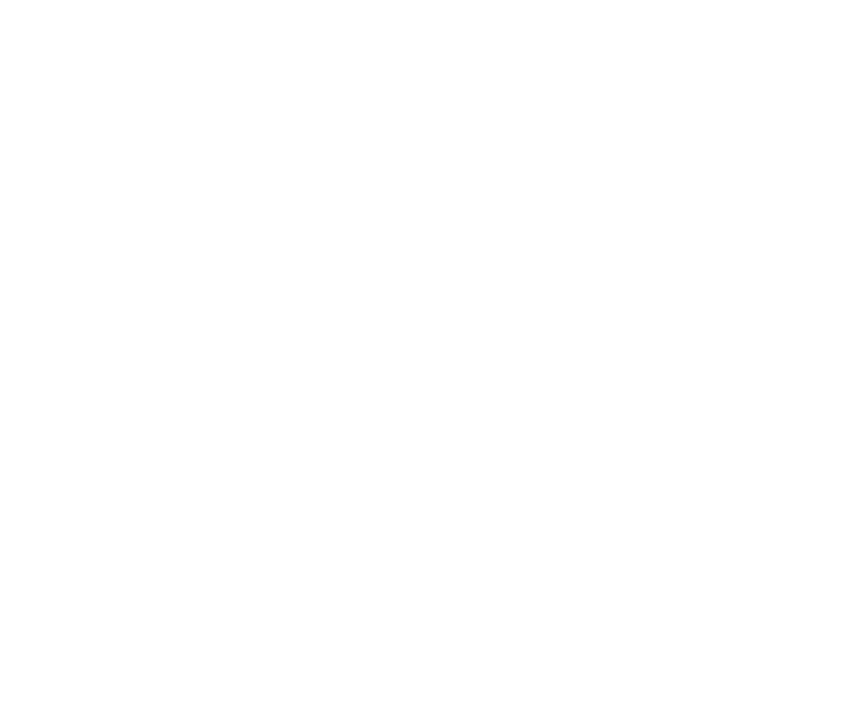

In [46]:
# Results
fig3 = plt.figure(figsize=(12,10))
ax1 = fig3.add_subplot(8,1,1)
ax4 = fig3.add_subplot(8,1,2)
ax2 = fig3.add_subplot(8,1,3)
ax5 = fig3.add_subplot(8,1,4)
ax7 = fig3.add_subplot(8,1,5)
ax8 = fig3.add_subplot(8,1,6)
ax3 = fig3.add_subplot(8,1,7)
ax6 = fig3.add_subplot(8,1,8)

# TRAINING
ax1.clear()
ax1.set_xlabel('iterations')
ax1.set_ylabel('training loss')
ax1.plot(loss_graph_train, label='bce loss')
ax1.legend(loc='upper left')

ax2.clear()
ax2.set_xlabel('iterations')
ax2.set_ylabel('training loss')
ax2.plot(kl_graph_train, label='kl loss')
ax2.legend(loc='upper left')

ax7.clear()
ax7.set_xlabel('iterations')
ax7.set_ylabel('class loss')
ax7.plot(class_graph_train, label='class loss', color='red')
ax7.legend(loc='upper left')

ax3.clear()
ax3.set_xlabel('iterations')
ax3.set_ylabel('training loss')
ax3.plot(*zip(*avg_loss_train), label='total loss', color='red')
ax3.legend(loc='upper left')

# EVALUATING
ax4.clear()
ax4.set_xlabel('iterations')
ax4.set_ylabel('testing loss')
ax4.plot(loss_graph_test, label='bce loss')
ax4.legend(loc='upper left')

ax5.clear()
ax5.set_xlabel('iterations')
ax5.set_ylabel('testing loss')
ax5.plot(kl_graph_test, label='kl loss')
ax5.legend(loc='upper left')

ax8.clear()
ax8.set_xlabel('iterations')
ax8.set_ylabel('class loss')
ax8.plot(class_graph_test, label='class loss')
ax8.legend(loc='upper left')

ax6.clear()
ax6.set_xlabel('iterations')
ax6.set_ylabel('testing loss')
ax6.plot(*zip(*avg_loss_test), label='total loss', color='red')
ax6.legend(loc='upper left')
fig3.canvas.draw()

In [47]:
model.eval()

FcVAE(
  (fc11): Linear(in_features=49152, out_features=512, bias=True)
  (fc12): Linear(in_features=49152, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=49152, bias=True)
)

<IPython.core.display.Javascript object>


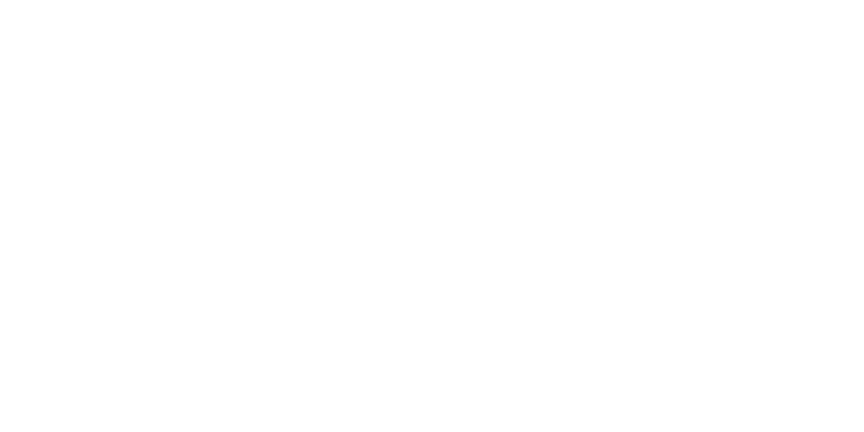

Text(0.5, 1.0, 'Reconstructed 0')

<IPython.core.display.Javascript object>


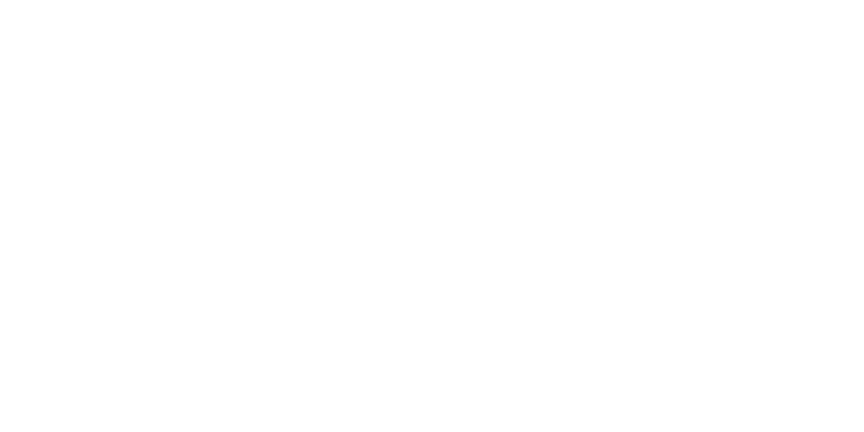

In [88]:
idx = np.random.randint(1, 800)
org_img = train_dataset[idx][0]
pic = train_dataset.dataset.get_image(idx)
test, _,label = train_dataset[idx]
inputs = test.cuda()
if model_type == 2:
    rec, mu, var,_ = model(inputs[None])
else:
    rec, mu, var = model(inputs[None])
rec = rec.view(-1, 3, 128, 128)
resp = rec.squeeze().permute(1, 2, 0).detach().cpu().numpy()

fig = plt.figure(figsize=(12,6))
fig.add_subplot(1, 2, 1)
plt.imshow(org_img.permute(1, 2, 0).numpy())
plt.title("Original")

# print(resp.shape)
# save_image(rec, 'sam.png')
fig.add_subplot(1, 2, 2)

plt.imshow(resp)
title = "Reconstructed " + str(label)
plt.title(title)

In [49]:
#END